<a href="https://colab.research.google.com/github/azhgh22/ML04_Facial_Expression_Recognition_Challenge/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
! unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip
! rm challenges-in-representation-learning-facial-expression-recognition-challenge.zip
! rm fer2013.tar.gz
! rm icml_face_data.csv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 27.7 MB/s eta 0:00:00
Mounted at /content/drive
 97% 276M/285M [00:01<00:00, 179MB/s]
100% 285M/285M [00:01<00:00, 229MB/s]
Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


**Imports**

In [22]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cuda


## **Slit data into Train(70%), Validation(15%), Test(15%)**

In [3]:
data = pd.read_csv("train.csv")

In [4]:
data.head(10)

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...
9,2,255 254 255 254 254 179 122 107 95 124 149 150...


In [5]:
train=data.sample(frac=0.7,random_state=7) # Create training of 70% of the data
test=data.drop(train.index) # Create testing by removing the 70% of the train data which will result in 30%

val=test.sample(frac=0.5,random_state=7) # Create validation of 50% of the testing data
test=test.drop(val.index) # Create testing by removing the 50% of the validation data which will result in 50%

In [6]:
data.shape

(28709, 2)

In [7]:
train.shape

(20096, 2)

In [8]:
train['emotion'].value_counts()

,count
emotion,
3,5035
6,3479
4,3402
2,2883
0,2811
5,2187
1,299


## **Custom DataSet class and Transformer**

In [9]:
train['emotion']

,emotion
14538,3
25662,2
413,5
917,6
7130,3
...,...
14779,1
13190,0
16056,4
8977,4


In [10]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(np.array(dataframe['emotion'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        pixels = [int(x) for x in self.dataframe.iloc[idx, 1].split()]
        label = self.labels[idx]

        image = Image.fromarray(np.array(pixels,dtype=np.uint8).reshape(48, 48))

        if self.transform:
            image = self.transform(image).to(device)

        return image, label

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.ConvertImageDtype(torch.float) # The values are in floating point numbers
    ]) # Transform all images into one clear format (preprocess all images to same properties)

In [12]:
small_dataset = CustomImageDataset(dataframe=train.sample(n=20,random_state=7),transform=transform)
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
val_dataset = CustomImageDataset(dataframe=val, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

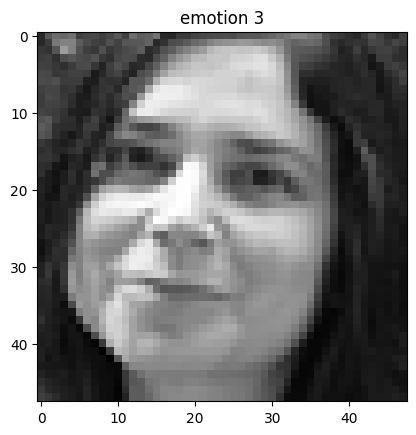

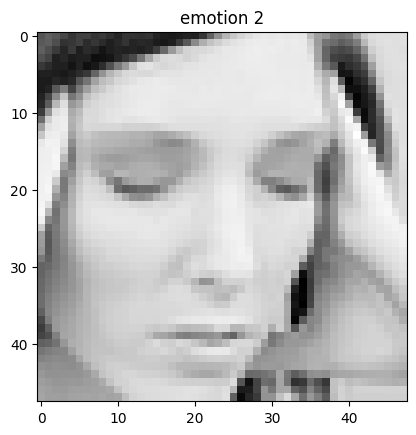

In [13]:
for i in range(2):
  img, label = train_dataset[i]

  plt.imshow(img.squeeze().cpu().numpy(),cmap='gray')
  plt.title(f"emotion {label}")
  plt.show()

## **Hyperparameters**

In [90]:
LR = 1e-4
BATCH_SIZE = 256
EPOCHS = 10
N_CLASSES = 7

# **Dataloaders**

In [91]:
small_loader = DataLoader(small_dataset,batch_size=20,shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## **Model**

In [52]:
model = nn.Sequential(
    nn.Conv2d(1,32,kernel_size=3,padding=1,stride=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Flatten(),
    nn.Linear(48*48*32,128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128,128),
    nn.ReLU(),
    nn.Linear(128,N_CLASSES)
).cuda()

## **Model Summary**

In [53]:
from torchsummary import summary
summary(model, input_size = (1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
              ReLU-2           [-1, 32, 48, 48]               0
       BatchNorm2d-3           [-1, 32, 48, 48]              64
           Flatten-4                [-1, 73728]               0
            Linear-5                  [-1, 128]       9,437,312
              ReLU-6                  [-1, 128]               0
       BatchNorm1d-7                  [-1, 128]             256
            Linear-8                  [-1, 128]          16,512
              ReLU-9                  [-1, 128]               0
           Linear-10                    [-1, 7]             903
Total params: 9,455,367
Trainable params: 9,455,367
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 2.25
Params size (MB): 36.07
Estima

## **Training**

In [85]:
def check_accuracy_part34(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

In [93]:
def train_part34(model, optimizer, data_loader ,epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(data_loader):
            model.train()  # put model to training mode
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % 100 == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(data_loader, model)
                print()

In [94]:
model = nn.Sequential(
    nn.Conv2d(1,32,kernel_size=3,padding=1,stride=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Flatten(),
    nn.Linear(48*48*32,128),
    nn.ReLU(),
    nn.Linear(128,N_CLASSES)
).cuda()
train_part34(model,Adam(model.parameters(), lr=LR),train_loader,20)

Iteration 0, loss = 1.9983
Got 2582 / 20096 correct (12.85)

Iteration 0, loss = 1.5132
Got 8633 / 20096 correct (42.96)

Iteration 0, loss = 1.2879
Got 10375 / 20096 correct (51.63)

Iteration 0, loss = 1.1608
Got 12116 / 20096 correct (60.29)

Iteration 0, loss = 0.9592
Got 13893 / 20096 correct (69.13)

Iteration 0, loss = 0.7817
Got 15236 / 20096 correct (75.82)

Iteration 0, loss = 0.6161
Got 16409 / 20096 correct (81.65)

Iteration 0, loss = 0.4478
Got 17780 / 20096 correct (88.48)

Iteration 0, loss = 0.3682
Got 18640 / 20096 correct (92.75)

Iteration 0, loss = 0.2985
Got 19190 / 20096 correct (95.49)

Iteration 0, loss = 0.2134
Got 19483 / 20096 correct (96.95)

Iteration 0, loss = 0.1535
Got 19797 / 20096 correct (98.51)

Iteration 0, loss = 0.1250
Got 19909 / 20096 correct (99.07)

Iteration 0, loss = 0.0897
Got 19997 / 20096 correct (99.51)

Iteration 0, loss = 0.0734
Got 20031 / 20096 correct (99.68)

Iteration 0, loss = 0.0472
Got 20038 / 20096 correct (99.71)

Iteration 

## **Testing**

In [96]:
train_accuracy = check_accuracy_part34(train_loader,model)
val_accuracy = check_accuracy_part34(val_loader,model)
print("train : ",train_accuracy)
print("validation : ",val_accuracy)

Got 20056 / 20096 correct (99.80)
Got 1923 / 4306 correct (44.66)
train :  0.9980095541401274
validation :  0.4465861588481189


## **Plotting Training Progress**

## **Log to Wandb**

In [97]:
! pip install wandb

In [98]:
! wandb login

wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: azhgh22 (azhgh22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [99]:
import random

import wandb

# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="azhgh22-free-university-of-tbilisi-",
    # Set the wandb project where this run will be logged.
    project="Face recognition",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": LR,
        "batch_size" : BATCH_SIZE,
        "epochs" : 20,
        "architecture": "CNN",
        "dataset": "CIFAR-100",
        "optimizer" : "Adam",
        "loss function" : "Cross-entropy loss"
    },
)

run.log({"train_acc": train_accuracy, "validation_acc": val_accuracy})

torch.save(model.state_dict(), 'conv1.pth')
wandb.save('conv1.pth')

# Finish the run and upload any remaining data.
run.finish()

wandb: Currently logged in as: azhgh22 (azhgh22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


train_acc,▁
validation_acc,▁
train_acc,0.99801
validation_acc,0.44659
